<a href="https://colab.research.google.com/github/lizardnote/NLP/blob/main/Gemma_2B_it_Full_Finetuning_llm_finetuing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from huggingface_hub import login

# Hugging Face API 토큰을 입력합니다.
api_token = "-"
login(api_token)

In [3]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:00:00


In [5]:
!git clone https://github.com/wikibook/llm-finetuning

Cloning into 'llm-finetuning'...
remote: Enumerating objects: 15641, done.
remote: Counting objects: 100% (15641/15641), done.
remote: Compressing objects: 100% (14543/14543), done.
remote: Total 15641 (delta 1096), reused 15637 (delta 1094), pack-reused 0 (from 0)
Receiving objects: 100% (15641/15641), 6.75 MiB | 7.40 MiB/s, done.
Resolving deltas: 100% (1096/1096), done.


In [6]:
#경로 이동
%cd /content/llm-finetuning/chapter3/3.4
!ls

/content/llm-finetuning/chapter3/3.4
Gemma_2B_it_Full_Finetuning.ipynb  requirements.txt


In [7]:
#필요한 라이브러리 설치
!pip install -r requirements.txt

In [3]:
!pip install "trl==0.8.6"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 13.6 MB/s eta 0:00:00


In [8]:
import torch
import wandb

from sklearn.model_selection import train_test_split

from transformers import (AutoTokenizer, AutoModelForCausalLM, TrainingArguments, pipeline, Trainer)
from transformers.integrations import WandbCallback
from trl import DataCollatorForCompletionOnlyLM # Changed import
import evaluate

model_name = "google/gemma-2b-it" # Corrected variable name
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    use_cache = False,  #임시 저장소(캐시) 사용하지 않아 메모리 아낄 수 있음 / 속도는 느려짐
    device_map="auto",  #gpu cpu 가능 환경에 따라 자동 선택
    torch_dtype=torch.bfloat16,
    #bfloat16가 수치 안정성이 더 뛰어나서 딥러닝에서 더 안정적으로 학습함
    #float16랑 메모리 사용량은 동일함

    low_cpu_mem_usage=True,   #cpu메모리 최소화 시키면서 모델 불러옴
    attn_implementation='eager',)
    #어텐션 알고리즘 옵션 설정 /
    #최적화된 알고리즘으로 빠른 속도와 적은 메모리 사용량이 장점

tokenizer = AutoTokenizer.from_pretrained(model_name)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
import datasets
dataset = datasets.load_dataset("jaehy12/news3")
element = dataset["train"][1]
element

{'original': ' “동선 봐도 도움이 안 되는 것 같아요.\n  어딘지 알아야 피해가고 조심할 텐데요.\n ”“확진자가 다녀간 곳은 방역 마쳤는데 동선 공개는 그 부근 일대를 싹 다 죽이자는 것 같아요.\n ” 최근 부천시 페이스북 신종 코로나바이러스 감염증(코로나19) 관련 게시물에는 확진자 동선 공개 범위를 성토하는 댓글이 여럿 달렸다.\n  물류센터·교회 발 코로나19 확산이 지역사회 N차 감염으로 이어지면서 확진자 동선을 확대 공개해야 한다는 주장이 제기된 가운데 사생활 침해 등을 근거로 반대하는 의견도 나오면서 동선공개 논란에 다시 불이 붙는 모양새다.\n  지난 2월 코로나19 초기엔 확진자 동선이 대부분 공개됐다.\n  쇼핑몰을 방문한 확진자가 시간대별로 어느 매장을 찾았는지 등의 동선이 지자체 소셜네트워크서비스(SNS)에 게재됐다.\n  이후 사생활 침해 논란이 일자 질본은 감염병 예방에 필요한 정보에 한해 확진자 정보를 공개하라는 권고사항을 발표했다.\n  권고사항에는 증상 발생 2일 전부터 격리일까지의 시간, 감염을 우려할 만큼의 확진자와의 접촉이 일어난 장소 및 수단 등을 공개한다는 내용이 담겼다.\n  해당 공간 내 모든 접촉자가 파악되면 공개하지 않을 수 있다는 단서도 추가됐다.\n  확진자가 마지막 접촉자와 만날 일로부터 14일이 지나면 공개한 동선을 삭제할 것도 권고했다.\n  확진 늘자 동선공개 확대 나선 지자체 물류센터·교회 등 집단감염에 이어 감염경로가 특정되지 않은 확진 사례가 늘면서 일부 지자체는 동선 공개 범위를 확대하고 있다.\n  김포시는 지난 2일부터 확진자 이동 경로에 따른 동선 공개 원칙을 제한적으로 확대했다.\n  시민 우려 불식을 위해 확진자 방문으로 접촉자가 다수 발생하고 확산이 우려되는 장소는 상호를 공개하기로 한 것이다.\n  앞서 부천 118번 확진자인 A씨(31)가 한 제약회사 영업사원인 사실이 알려지면서 SNS에 그가 다닌 병원 정보가 공유됐다.\n  장덕천 부천시장은 “SNS에 A씨가 평소

### 3.4.3. 데이터셋

In [ ]:
def get_chat_format(example):

        return [
            {"role": "user", "content": f"다음 텍스트를 한국어로 간단히 요약 및 관련 키워를 추출해주세요:\n{example['original']}"},
            {"role": "assistant", "content": f"한국어 요약:\n{example['summary']}"}
        ]

In [ ]:
formatted = tokenizer.apply_chat_template(
    get_chat_format(element), tokenize=False
)

### 3.4.4. Gemma 모델 기능 확인

#### 키워드 추출 기능 확인

In [9]:
input_text = """다음 텍스트를 한국어로 간단히 요약해주세요:\n부산의 한 왕복 2차선 도로에서 역주행 사고로 배달 오토바이 운전자인 고등학생이 숨지는 사고가 발생했다.
유족은 '가해자가 사고 후 곧바로 신고하지 않고 늑장 대응해 피해를 키웠다'고 주장하고 있다.
11일 부산진경찰서는 교통사고처리특례법(교통사고처리법)상 업무상 과실치사 혐의로 지난 3일 A(59)씨를 검찰에 불구속 송치했다고 밝혔다.
A씨는 교통사고처리법상 12대 중과실에 해당되는 '중앙선 침범'으로 역주행 교통사고를 일으킨 혐의를 받는다.
경찰에 따르면 스포츠유틸리티차량(SUV) 운전자 A씨는 5월 19일 밤 11시 50분쯤 부산진구 가야고가교 밑 도로에서 중앙선을 넘어 역주행으로 140m를 달려
반대편 차선의 오토바이 운전자 조모(16)군을 들이받았다. 조군은 원동기장치자전거 면허를 취득한 상태였고 헬멧도 쓰고 있었지만 크게 다쳤다.
사고 당일 수술을 받았으나 얼마 후 2차 뇌출혈로 뇌사 판정이 내려졌고, 사고 발생 약 한 달 만인 지난달 16일 끝내 사망했다.
사고를 낸 A씨는 술을 마시거나 약물을 복용한 상태에서 운전하지는 않은 것으로 조사됐다.
경찰 관계자는 'A씨가 자신이 정주행을 하고 오토바이가 역주행을 한 것으로 착각했다고 진술했다'고 설명했다."""

def change_inference_chat_format(input_text):
    return [
    {"role": "user", "content": f"{input_text}"},
	{"role": "assistant", "content": """부산의 한 왕복 2차선 도로에서 역주행 사고로 배달 오토바이 운전자인 고등학생이 숨지는 사고가 발생했다.
     유족은 '가해자가 사고 후 곧바로 신고하지 않고 늑장 대응해 피해를 키웠다'고 주장하고 있다."""},
    {"role": "user", "content": "중요한 키워드 5개를 뽑아주세요."},
    {"role": "assistant", "content": ""}
    ]
prompt = change_inference_chat_format(input_text)
# tokenizer 초기화 및 적용
inputs = tokenizer.apply_chat_template(
    prompt,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt"
    ).to(model.device)
outputs = model.generate(
    input_ids=inputs.to(model.device),
    max_new_tokens=256
    )
print(tokenizer.decode(
    outputs[0],
    skip_special_tokens=True
    ))

user
다음 텍스트를 한국어로 간단히 요약해주세요:
부산의 한 왕복 2차선 도로에서 역주행 사고로 배달 오토바이 운전자인 고등학생이 숨지는 사고가 발생했다.
유족은 '가해자가 사고 후 곧바로 신고하지 않고 늑장 대응해 피해를 키웠다'고 주장하고 있다.
11일 부산진경찰서는 교통사고처리특례법(교통사고처리법)상 업무상 과실치사 혐의로 지난 3일 A(59)씨를 검찰에 불구속 송치했다고 밝혔다.
A씨는 교통사고처리법상 12대 중과실에 해당되는 '중앙선 침범'으로 역주행 교통사고를 일으킨 혐의를 받는다.
경찰에 따르면 스포츠유틸리티차량(SUV) 운전자 A씨는 5월 19일 밤 11시 50분쯤 부산진구 가야고가교 밑 도로에서 중앙선을 넘어 역주행으로 140m를 달려
반대편 차선의 오토바이 운전자 조모(16)군을 들이받았다. 조군은 원동기장치자전거 면허를 취득한 상태였고 헬멧도 쓰고 있었지만 크게 다쳤다.
사고 당일 수술을 받았으나 얼마 후 2차 뇌출혈로 뇌사 판정이 내려졌고, 사고 발생 약 한 달 만인 지난달 16일 끝내 사망했다.
사고를 낸 A씨는 술을 마시거나 약물을 복용한 상태에서 운전하지는 않은 것으로 조사됐다.
경찰 관계자는 'A씨가 자신이 정주행을 하고 오토바이가 역주행을 한 것으로 착각했다고 진술했다'고 설명했다.
model
부산의 한 왕복 2차선 도로에서 역주행 사고로 배달 오토바이 운전자인 고등학생이 숨지는 사고가 발생했다.
     유족은 '가해자가 사고 후 곧바로 신고하지 않고 늑장 대응해 피해를 키웠다'고 주장하고 있다.
user
중요한 키워드 5개를 뽑아주세요.
model

model
- 부산의 한 왕복 2차선 도로에서 역주행 사고
- 배달 오토바이 운전자
- 고등학생
- 유족
- 늑장 대응


키워드를 생성하는 능력이 Gemma에게 있는 것을 확인했습니다.

#### 요약 기능 확인

In [10]:
# Input_text : 위 정의된 기사와 동일

def change_inference_chat_format(input_text):
    return [
    {"role": "user", "content": f"{input_text}"},
    {"role": "assistant", "content": "한국어 요약:\n"}
    ]

# chat template 적용
prompt = change_inference_chat_format(input_text)

# 생성
inputs = tokenizer.apply_chat_template(prompt, tokenize=True, add_generation_prompt=True, return_tensors="pt").to(model.device)
outputs = model.generate(inputs, max_new_tokens=256, use_cache=True)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

user
다음 텍스트를 한국어로 간단히 요약해주세요:
부산의 한 왕복 2차선 도로에서 역주행 사고로 배달 오토바이 운전자인 고등학생이 숨지는 사고가 발생했다.
유족은 '가해자가 사고 후 곧바로 신고하지 않고 늑장 대응해 피해를 키웠다'고 주장하고 있다.
11일 부산진경찰서는 교통사고처리특례법(교통사고처리법)상 업무상 과실치사 혐의로 지난 3일 A(59)씨를 검찰에 불구속 송치했다고 밝혔다.
A씨는 교통사고처리법상 12대 중과실에 해당되는 '중앙선 침범'으로 역주행 교통사고를 일으킨 혐의를 받는다.
경찰에 따르면 스포츠유틸리티차량(SUV) 운전자 A씨는 5월 19일 밤 11시 50분쯤 부산진구 가야고가교 밑 도로에서 중앙선을 넘어 역주행으로 140m를 달려
반대편 차선의 오토바이 운전자 조모(16)군을 들이받았다. 조군은 원동기장치자전거 면허를 취득한 상태였고 헬멧도 쓰고 있었지만 크게 다쳤다.
사고 당일 수술을 받았으나 얼마 후 2차 뇌출혈로 뇌사 판정이 내려졌고, 사고 발생 약 한 달 만인 지난달 16일 끝내 사망했다.
사고를 낸 A씨는 술을 마시거나 약물을 복용한 상태에서 운전하지는 않은 것으로 조사됐다.
경찰 관계자는 'A씨가 자신이 정주행을 하고 오토바이가 역주행을 한 것으로 착각했다고 진술했다'고 설명했다.
model
한국어 요약:
model
부산의 한 왕복 2차선 도로에서 역주행 사고로 배달 오토바이 운전자인 고등학생이 숨지는 사고가 발생했다. 유족은 '가해자가 사고 후 곧바로 신고하지 않고 늑장 대응해 피해를 키웠다'고 주장하고 있다. 경찰은 교통사고처리법상 업무상 과실치사 혐의로 지난 3일 A(59)씨를 검찰에 불구속 송치했다.


In [11]:
# Input_text : 위 정의된 기사와 동일

def change_inference_chat_format(input_text):
    return [
    {"role": "user", "content": f"다음 텍스트를 한국어로 간단히 요약하고, 관련된 5개의 키워를 추출해주세요:\n{input_text}"},
	{"role": "assistant", "content": ""},
    ]
prompt = change_inference_chat_format(input_text)
# tokenizer 초기화 및 적용t\
inputs = tokenizer.apply_chat_template(prompt, tokenize=True, add_generation_prompt=True, return_tensors="pt").to(model.device)
outputs = model.generate(inputs, max_new_tokens=256, use_cache=True)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

KeyboardInterrupt: 

### 3.4.5. 키워드 데이터 생성

In [ ]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto")
def key_word_prompt(input_text, summary_text):
    return [
    {"role": "user", "content": f"{input_text}"},
    {"role": "assistant", "content": f"{summary_text}"},
    {"role": "user", "content": "중요한 키워드 5개를 뽑아주세요."},
    {"role": "assistant", "content": ""}
    ]

def extract_keywords_batch(batch):
    prompts = [key_word_prompt(original, summary) for original, summary in zip(batch["original"], batch["summary"])]

    generated_texts = pipe(prompts, max_new_tokens=150, return_full_text=False)
    keywords = [gen_text[0]["generated_text"] for gen_text in generated_texts]
    batch["keywords"] = keywords
    return batch


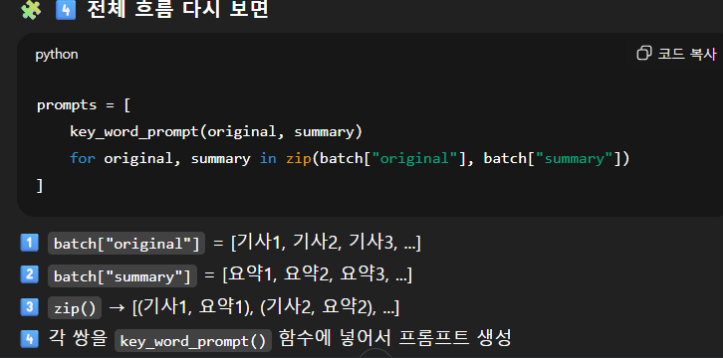

허깅페이스의 pipeline() 사용해서 텍스트 생성용 모델 파이프라인을 만드는데,

프롬프트 -> 모델 답변 생성 -> 결과 반환하는 함수 객체

In [ ]:
# dataset에 keyword 열 추가 (batch 단위로 처리)
sample_dataset = dataset["train"].shuffle(seed=42).select(range(1000))
sample_dataset = sample_dataset.map(extract_keywords_batch, batched=True, batch_size=20)  # 적절한 batch_size 선택

sample_dataset

In [ ]:
sample_dataset[0]

{'original': '전두환 정권을 흔들었던 \'큰 손\' 장영자의 네 번째 유죄가 확정됐다.\n  혐의는 사기, 징역은 4년이다.\n  대법원 2부(주심 박상옥 대법관)는 9일 무죄를 주장한 장씨의 상고를 기각했다.\n  장씨는 지인들에게서 세 차례에 걸쳐 6억여원을 가로채고 이들에게 위조 수표로 수억원을 요구한 혐의를 받는다.\n  올해로 76세를 맞은 장씨는 이미 복역을 마친 29년을 포함해 인생의 절반가량인 33년을 감옥에서 보내게됐다.\n   우수한 인재에게만 허락된다는 숙명여대 \'5월의 여왕(메이퀸)\' 출신인 장영자의 노년이 씁쓸하다.\n  장씨는 전두환 전 대통령의 처삼촌인 고(故) 이규광씨의 처제이자, 중앙정보부 차장이었던 고(故) 이철희씨의 아내였다.\n  전두환 정권 흔든 장영자의 삶장씨의 앞선 범행과 비교해 네 번째 사기 액수는 그 규모가 상당히 줄어든 편이다.\n  장씨는 1980년대 전두환 전 대통령과 남편을 내세워 자금 압박에 시달리던 기업에 자금을 빌려준 뒤 몇 배에 달하는 어음을 할인 유통하며 이득을 챙겼다.\n  그 규모가 총 7111억원에 달했다.\n  장씨는 이중 6404억원의 어음을 할인해 사용했다.\n   실체가 없던 어음은 부도가 났고 기업들은 도산했다.\n  장씨는 이 첫 번째 사기로 15년형을 선고받았다.\n  10년만인 1992년에 가석방됐다.\n  전두환 전 대통령의 부인 이순자씨는 자서전 『당신은 외롭지 않다』에서 이를 "조금씩 민심도 안정되고 경제도 생기를 되찾아 (남편이) 자신감을 얻던 시점에 날벼락같이 찾아온 횡액과도 같은 사건"이라 회고했다.\n  장씨가 당시 법정에서 아직 시중에 유통중인 어음이 있다며 "경제는 유통""나는 권력투쟁의 희생양이라"이라 했던 말은 유행어가 됐다.\n  \'장영자 어음할인 사건\' 수사 축소 의혹으로 두 명의 법무부 장관이 경질됐다.\n   "누나 성질 급하다" 70대 장영자의 돈 요구장씨는 출소한지 2년만인 1994년에 140억원대 차용 사기를 저질렀다.\n  두 번

### 3.4.6 데이터 전처리

In [ ]:
def chat_keyword_summary_format(example):

        return [
            {"role": "user", "content": f"다음 텍스트를 한국어로 간단히 요약 및 관련 키워를 추출해주세요:\n{example['original']}"},
            {"role": "assistant", "content": f"한국어 요약:{example['summary']}\n키워드:{example['keywords']}"}
        ]

formatted = tokenizer.apply_chat_template(
    chat_keyword_summary_format(sample_dataset[0]), tokenize=False
)
print(formatted)

<bos><start_of_turn>user
다음 텍스트를 한국어로 간단히 요약 및 관련 키워를 추출해주세요:
전두환 정권을 흔들었던 '큰 손' 장영자의 네 번째 유죄가 확정됐다.
  혐의는 사기, 징역은 4년이다.
  대법원 2부(주심 박상옥 대법관)는 9일 무죄를 주장한 장씨의 상고를 기각했다.
  장씨는 지인들에게서 세 차례에 걸쳐 6억여원을 가로채고 이들에게 위조 수표로 수억원을 요구한 혐의를 받는다.
  올해로 76세를 맞은 장씨는 이미 복역을 마친 29년을 포함해 인생의 절반가량인 33년을 감옥에서 보내게됐다.
   우수한 인재에게만 허락된다는 숙명여대 '5월의 여왕(메이퀸)' 출신인 장영자의 노년이 씁쓸하다.
  장씨는 전두환 전 대통령의 처삼촌인 고(故) 이규광씨의 처제이자, 중앙정보부 차장이었던 고(故) 이철희씨의 아내였다.
  전두환 정권 흔든 장영자의 삶장씨의 앞선 범행과 비교해 네 번째 사기 액수는 그 규모가 상당히 줄어든 편이다.
  장씨는 1980년대 전두환 전 대통령과 남편을 내세워 자금 압박에 시달리던 기업에 자금을 빌려준 뒤 몇 배에 달하는 어음을 할인 유통하며 이득을 챙겼다.
  그 규모가 총 7111억원에 달했다.
  장씨는 이중 6404억원의 어음을 할인해 사용했다.
   실체가 없던 어음은 부도가 났고 기업들은 도산했다.
  장씨는 이 첫 번째 사기로 15년형을 선고받았다.
  10년만인 1992년에 가석방됐다.
  전두환 전 대통령의 부인 이순자씨는 자서전 『당신은 외롭지 않다』에서 이를 "조금씩 민심도 안정되고 경제도 생기를 되찾아 (남편이) 자신감을 얻던 시점에 날벼락같이 찾아온 횡액과도 같은 사건"이라 회고했다.
  장씨가 당시 법정에서 아직 시중에 유통중인 어음이 있다며 "경제는 유통""나는 권력투쟁의 희생양이라"이라 했던 말은 유행어가 됐다.
  '장영자 어음할인 사건' 수사 축소 의혹으로 두 명의 법무부 장관이 경질됐다.
   "누나 성질 급하다" 70대 장영자의 돈 요구장씨는 출소한지 2년만인 1994년에 1

In [ ]:
EOS_TOKEN = tokenizer.eos_token
def tokenize(element):
    formatted = tokenizer.apply_chat_template(
        chat_keyword_summary_format(element), tokenize=False
    ) + EOS_TOKEN
    outputs = tokenizer(formatted)
    return {
        "input_ids": outputs["input_ids"],
        "attention_mask": outputs["attention_mask"],
    }

tokenized_sample_dataset = sample_dataset.map(tokenize)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

chat_keyword_summary_format(element) 로 대화형 프롬프트 형태로 변환 (user/assistant 구조로 바꿈)

tokenizer.apply_chat_template(...) 로 특수토큰(예: , user)이 추가된 문장 생성

마지막에 EOS_TOKEN 붙여서 “대화 종료” 표시.

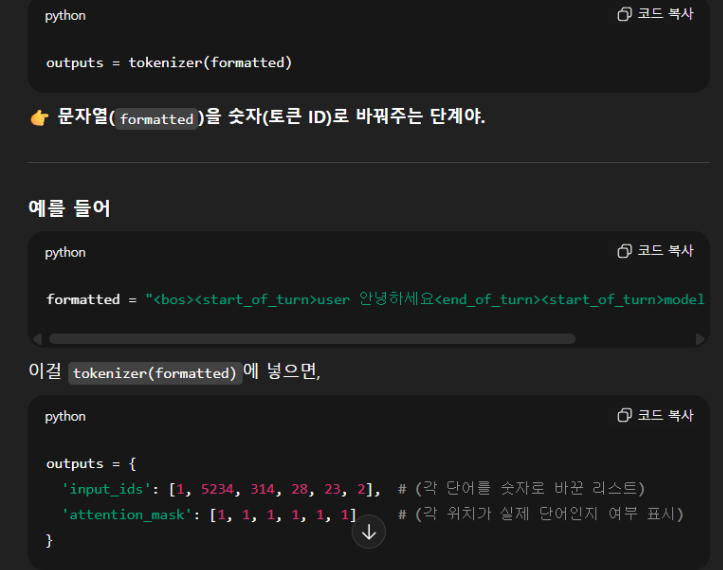

- input_ids 는 문장의 각 단어/기호를 숫자로 인코딩 한 배열
- attention_mask 는 패딩 부분은 무시하도록 도와주는 마스크

### 3.4.7. 데이터셋 분리 및 콜레이터 설정

In [ ]:
tokenized_sample_dataset = tokenized_sample_dataset.train_test_split(
    test_size=0.1,
    seed=42
)
tokenized_sample_dataset

DatasetDict({
    train: Dataset({
        features: ['original', 'summary', 'keywords', 'input_ids', 'attention_mask'],
        num_rows: 900
    })
    test: Dataset({
        features: ['original', 'summary', 'keywords', 'input_ids', 'attention_mask'],
        num_rows: 100
    })
})

In [ ]:
# 데이터를 직접 만드는데, 1시간 이상 소요되므로 제가 미리 만들어놓았습니다.
# 필요하신 분들은 주석을 풀고 사용해주세요

# sample_dataset = datasets.load_dataset("daje/keyword_summary")
# print(sample_dataset["train"][0])
# tokenized_sample_dataset = sample_dataset.map(tokenize)
# tokenized_sample_dataset = tokenized_sample_dataset['train'].train_test_split(test_size=0.1, seed=42)
# tokenized_sample_dataset


In [ ]:
response_template_ids = tokenizer.encode(
    "<start_of_turn>model\n",
    add_special_tokens=False
    )

#collator의 역할은 모델이 학습할 부분에 라벨을 달아 정확히 학습할 부분을 지정해준다.
collator = DataCollatorForCompletionOnlyLM(
    response_template_ids, tokenizer=tokenizer
)

데이터 콜레이터 설정

DataCollatorForCompletionOnlyLM 은 TRL이 제공하는 콜레이터인데

역할이 **“프롬프트 부분(user) 은 학습에서 빼고, 답변 부분(assistant/model)만 학습하도록 마스크 씌움

그럼 모델은 “사용자가 했던 말”을 맞추려고 노력하지 않고
“모델이 해야 할 답변”만 맞추려고 함 → 우리가 원하는 파인튜닝

그래서 위에서 인코딩해둔 response_template_ids 를 넘겨주는 거야.
“이 토큰 시퀀스가 보이면 그 다음부턴 정답이야” 라고 알려주게 된다.

### 3.4.8 학습 파라미터 설정

In [ ]:
wandb.init(project="gemma-2B-it-Full-Fine-Tuning", entity="Your_ID")

training_args = TrainingArguments(
    output_dir="./keywords_gemma_results",
    # num_train_epochs=1, # 1epoch에 250step정도 진행함
    max_steps=800,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    warmup_steps=0,
    weight_decay=0.01,
    learning_rate=2e-4,
    logging_dir="./logs",
    logging_steps=100,
    report_to="wandb",
    )

### 3.4.9 평가 메트릭 정의

In [ ]:
#계산 메트릭 로
bleu = evaluate.load("bleu")
acc = evaluate.load("accuracy")

def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        # 모델과 설정에 따라 logits에는 추가적인 텐서들이 포함될 수 있습니다.
        # 예를 들어, past_key_values 같은 것들이 있을 수 있지만,
        # logits는 항상 첫 번째 요소입니다.
        logits = logits[0]
    # 토큰 ID를 얻기 위해 argmax를 수행합니다.
    return logits.argmax(dim=-1)
    #“각 토큰 위치에서 가장 확률 높은 단어 id만 뽑아


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # preds는 labels와 같은 형태를 갖습니다.
    # preprocess_logits_for_metrics에서 argmax(-1)가 계산된 후입니다.
    # 하지만 우리는 labels를 한 칸 이동시켜야 합니다.
    labels = labels[:, 1:]
    preds = preds[:, :-1]

    # -100은 DataCollatorForCompletionOnlyLM에서 사용되는
    # ignore_index의 기본값입니다.
    mask = labels == -100
    # -100을 토크나이저가 디코드할 수 있는 값으로 대체합니다.
    labels[mask] = tokenizer.pad_token_id
    preds[mask] = tokenizer.pad_token_id

    # BLEU 점수는 텍스트를 입력으로 받기 때문에,
    # 토큰 ID에서 텍스트로 변환해야 합니다.
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    bleu_score = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    #이러면 “모델이 뽑은 문장” vs “정답 문장”의 유사도를 볼 수 있음.

    # accuracy는 정수 리스트를 입력으로 받습니다.
    # 우리는 -100이 아닌 부분만 평가하고 싶기 때문에,
    # 마스크의 부정(~)을 사용합니다.
    accuracy = acc.compute(predictions=preds[~mask], references=labels[~mask])

    return {**bleu_score, **accuracy}

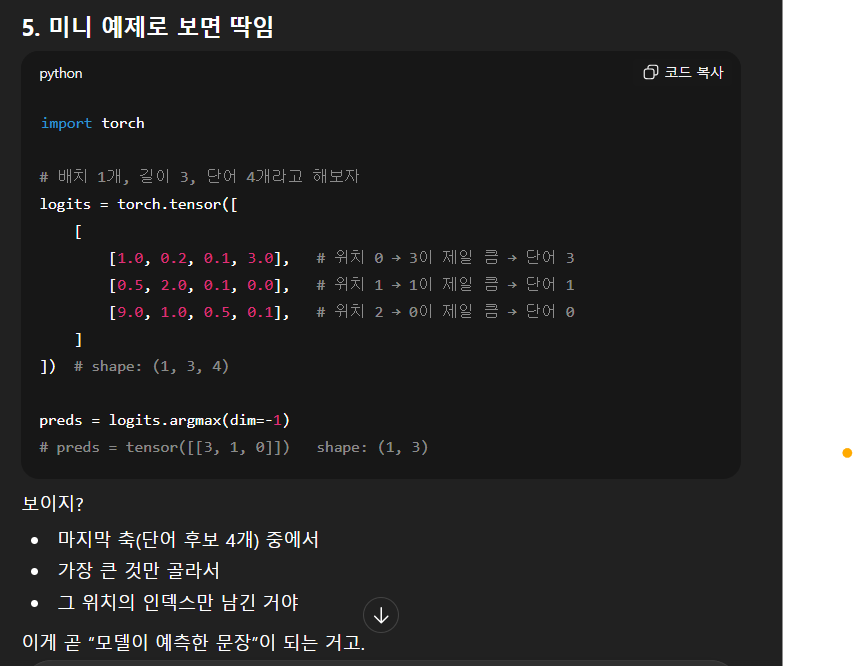

### 3.4.10 모델 학습 및 평가

In [ ]:
trainer = Trainer(
    args=training_args,
    model=model,
    tokenizer=tokenizer,
    data_collator=collator,
    train_dataset=tokenized_sample_dataset["train"],
    eval_dataset=tokenized_sample_dataset["test"],
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
    compute_metrics=compute_metrics,
    callbacks=[WandbCallback()]
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
You are adding a <class 'transformers.integrations.integration_utils.WandbCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
WandbCallback
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer.train()

Step,Training Loss
100,0.713900
200,0.696900
300,0.462000
400,0.354700
500,0.234600
600,0.089300
700,0.073600
800,0.016900


TrainOutput(global_step=800, training_loss=0.33024674639105794, metrics={'train_runtime': 374.1809, 'train_samples_per_second': 8.552, 'train_steps_per_second': 2.138, 'total_flos': 4.364570866724045e+16, 'train_loss': 0.33024674639105794, 'epoch': 3.5555555555555554})

trainer.train() 하면 Trainer가 이런 일을 자동으로 해줘:

train_dataset에서 배치 하나 뽑음

그 배치를 data_collator 에게 줌
→ collator가 패딩 맞추고
→ “이 부분은 예측하지 마 (loss=-100)” 처리하고
→ 모델이 먹을 수 있는 딕셔너리로 바꿔줌

그걸 model(**batch) 로 넣어서 forward

loss 계산

optimizer로 업데이트

logging_steps마다 로그

eval_steps마다 eval_dataset으로 trainer.evaluate() 자동 실행

In [ ]:
trainer.evaluate()

{'eval_loss': 0.9304771423339844,
 'eval_bleu': 0.5572014773043237,
 'eval_precisions': [0.7583783783783784,
  0.621651376146789,
  0.5123364485981309,
  0.43733333333333335],
 'eval_brevity_penalty': 0.9773769446405759,
 'eval_length_ratio': 0.9776290294169455,
 'eval_translation_length': 5550,
 'eval_reference_length': 5677,
 'eval_accuracy': 0.8690894073921124,
 'eval_runtime': 3.7681,
 'eval_samples_per_second': 26.539,
 'eval_steps_per_second': 3.45,
 'epoch': 3.5555555555555554}

#### 3.4.11 파인튜닝한 모델 테스트

In [ ]:
input_text = "부산의 한 왕복 2차선 도로에서 역주행 사고로 배달 오토바이 운전자인 고등학생이 숨지는 사고가 발생했다. 유족은 '가해자가 사고 후 곧바로 신고하지 않고 늑장 대응해 피해를 키웠다'고 주장하고 있다.\n11일 부산진경찰서는 교통사고처리특례법(교통사고처리법)상 업무상 과실치사 혐의로 지난 3일 A(59)씨를 검찰에 불구속 송치했다고 밝혔다. A씨는 교통사고처리법상 12대 중과실에 해당되는 '중앙선 침범'으로 역주행 교통사고를 일으킨 혐의를 받는다.\n경찰에 따르면 스포츠유틸리티차량(SUV) 운전자 A씨는 5월 19일 밤 11시 50분쯤 부산진구 가야고가교 밑 도로에서 중앙선을 넘어 역주행으로 140m를 달려 반대편 차선의 오토바이 운전자 조모(16)군을 들이받았다. 조군은 원동기장치자전거 면허를 취득한 상태였고 헬멧도 쓰고 있었지만 크게 다쳤다. 사고 당일 수술을 받았으나 얼마 후 2차 뇌출혈로 뇌사 판정이 내려졌고, 사고 발생 약 한 달 만인 지난달 16일 끝내 사망했다. 사고를 낸 A씨는 술을 마시거나 약물을 복용한 상태에서 운전하지는 않은 것으로 조사됐다. 경찰 관계자는 'A씨가 자신이 정주행을 하고 오토바이가 역주행을 한 것으로 착각했다고 진술했다'고 설명했다."

def get_chat_format(input_text):

        return [
            {"role": "user", "content": f"다음 텍스트를 한국어로 간단히 요약 및 관련 키워드를 추출해주세요:\n{input_text}"},
            {"role": "assistant", "content": "한국어 요약:\n키워드:"}
        ]


def change_inference_chat_format(input_text):
    return [
    {"role": "user", "content": f"{input_text}"},
    {"role": "assistant", "content": ""}
    ]
prompt = change_inference_chat_format(input_text)

# tokenizer 초기화 및 적용t\

inputs = tokenizer.apply_chat_template(prompt, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")

outputs = model.generate(inputs, max_new_tokens=512, use_cache=True)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

user
부산의 한 왕복 2차선 도로에서 역주행 사고로 배달 오토바이 운전자인 고등학생이 숨지는 사고가 발생했다. 유족은 '가해자가 사고 후 곧바로 신고하지 않고 늑장 대응해 피해를 키웠다'고 주장하고 있다.
11일 부산진경찰서는 교통사고처리특례법(교통사고처리법)상 업무상 과실치사 혐의로 지난 3일 A(59)씨를 검찰에 불구속 송치했다고 밝혔다. A씨는 교통사고처리법상 12대 중과실에 해당되는 '중앙선 침범'으로 역주행 교통사고를 일으킨 혐의를 받는다.
경찰에 따르면 스포츠유틸리티차량(SUV) 운전자 A씨는 5월 19일 밤 11시 50분쯤 부산진구 가야고가교 밑 도로에서 중앙선을 넘어 역주행으로 140m를 달려 반대편 차선의 오토바이 운전자 조모(16)군을 들이받았다. 조군은 원동기장치자전거 면허를 취득한 상태였고 헬멧도 쓰고 있었지만 크게 다쳤다. 사고 당일 수술을 받았으나 얼마 후 2차 뇌출혈로 뇌사 판정이 내려졌고, 사고 발생 약 한 달 만인 지난달 16일 끝내 사망했다. 사고를 낸 A씨는 술을 마시거나 약물을 복용한 상태에서 운전하지는 않은 것으로 조사됐다. 경찰 관계자는 'A씨가 자신이 정주행을 하고 오토바이가 역주행을 한 것으로 착각했다고 진술했다'고 설명했다.
model

model
한국어 요약:유족은 '가해자가 사고 후 곧바로 신고하지 않고 늑장 대응해 피해를 키웠다'고 주장하고 있다. 11일 부산진경찰서는 교통사고처리특례법(교통사고처리법)상 업무상 과실치사 혐의로 지난 3일 A(59)씨를 검찰에 불구속 송치했다고 밝혔다.
키워드:1. 가해자가 사고 후 곧바로 신고하지 않고 늑장 대응해 피해를 키웠다
2. 고등학생
3. 유족
4. 2차선
5. 농장 대응

